In [1]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [2]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [3]:
emb_df = pd.read_csv('../data/embedding/Doc2Vec_embedding_output.csv',index_col=0)

In [4]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.146739,-2.738958,3.672001,4.319488,2.060131,1.106603,2.756807,-1.807586,3.119252,-0.814754,...,2.498754,-1.766720,0.291909,-0.236563,0.366089,-2.615653,2.517367,-2.121267,4.024024,1.430665
1,-3.081997,-4.560731,-0.439482,2.801814,-2.063705,0.320462,2.700044,-1.313459,2.488874,-1.288608,...,3.506879,1.340675,0.644034,0.583566,-1.396967,-2.599615,0.540591,-0.846946,0.476570,1.209218
2,-0.923654,-0.931160,0.270649,0.993372,1.246490,1.068892,0.833382,-0.559276,1.961053,-4.149379,...,5.081479,1.130174,-2.890191,-2.820214,1.395403,-3.846228,-1.152302,-2.224700,1.176310,-0.315757
3,-0.047425,-3.906727,0.635823,0.752494,1.742398,0.973911,0.725889,-0.415176,3.048928,-2.944524,...,3.968297,0.803104,-1.049701,-2.646564,0.847253,-2.600662,-0.752832,0.028893,-0.424166,-1.445955
4,-6.648052,-0.395714,2.429264,2.590817,-0.684888,-1.006098,0.028183,2.124310,1.596855,-2.533973,...,-1.403458,-1.843892,-0.527678,-3.595732,-2.341160,-1.960664,-0.313663,-3.191498,0.681570,-2.437148


In [5]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [6]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [7]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [8]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/lower_bound.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 'cave_rescue'

label2 = pd.read_csv('../data/raw/labels/duckboat/lower_bound.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 'duckboat'

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/lower_bound.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 'helsinki'

In [9]:
label_df = pd.concat([label1, label2, label3])
label_df

,canonicalUrl,label
0,bbc.com/news/av/world-asia-44875089/thai-cave-...,cave_rescue
1,indystar.com/story/news/nation-now/2018/07/16/...,cave_rescue
2,washingtonpost.com/world/asia_pacific/these-di...,cave_rescue
3,au.news.yahoo.com/navy-seal-died-thai-cave-res...,cave_rescue
4,yahoo.com/news/m/8adca8cd-6cc3-307c-b109-9cd1d...,cave_rescue
...,...,...
487,chicago.suntimes.com/news/military-veterans-di...,helsinki
488,dailycaller.com/2018/07/19/mike-huckabee-media...,helsinki
489,sfgate.com/news/politics/article/trump-embrace...,helsinki
490,yahoo.com/news/m/78f6000e-d04c-355b-867d-8d5c8...,helsinki


In [10]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [11]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [12]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((140, 10), (176524, 10))

Sample and include all the labeled article

In [13]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])

In [14]:
sample_emb_df = emb_df.loc[sample_df.index]

In [15]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(sample_emb_df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [16]:
admat = nn.kneighbors_graph( mode='connectivity'); admat

<10140x10140 sparse matrix of type '<class 'numpy.float64'>'
	with 101400 stored elements in Compressed Sparse Row format>

In [17]:
G = nx.from_scipy_sparse_matrix(admat)

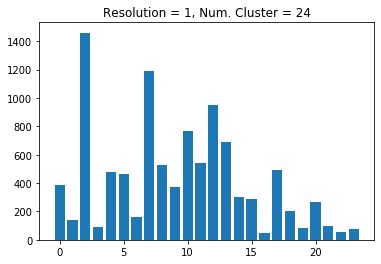

In [18]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [19]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(2, 1460, 337.5)

In [20]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [21]:
pc = clusters# prune_cluster(cluster, 5)

In [22]:
article_cluster = list(map(lambda d: sample_df.iloc[d[1]], pc.items()))
len(article_cluster)

24

In [23]:
len(article_cluster[0].title.tolist())

388

In [24]:
pc.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [25]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()[:10]))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()[:10]))))

-------------------------------------------------- title --------------------------------------------------
At least 8 reported dead as duck boat sinks near Branson, Mo. Divers search for survivors.
Top Democrats shy away from using word ‘treason’ with
Australian divers who helped rescue the  team from a cave will receive civilian honors
Alexander McQueen's most iconic fashion moments
Kansas City  Medicine and Biosciences named 2018 Great College to Work For - Houston Chronicle
Minnesota native gymnast who was first to speak up about Nasser sex abuse to be honored | The Globe
Magic Johnson Reveals What Worried Him About LeBron James Talks | HuffPost
Merkel responds to Trump jab on Montenegro | WTOP
The Prodigy announce new
AutoZone pays $3.3 million for Bridgeport family’s deaths - New Haven Register
-------------------------------------------------- text --------------------------------------------------
At least 8 reported dead as duck boat sinks near Branson, Mo. Divers search for s

## Top clusters

In [26]:
cluster_sizes = np.array(list(map(len, article_cluster)))

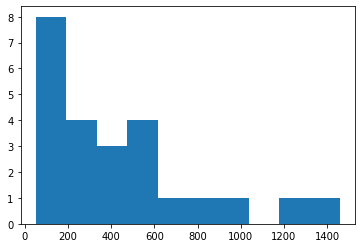

In [27]:
plt.hist(cluster_sizes);

In [28]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1460, 1191,  951,  770,  688,  538,  530,  495,  480,  466,  388,
        372,  303,  285,  268,  202,  164,  142,   96,   88,   81,   73,
         58,   51])

In [29]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
10801,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki
41640,36,wsj.com/articles/eight-die-after-boat-capsizes...,7/19/2018 11:51:12 PM -04:00,Eight Die After Boat Capsizes in Storm Near Br...,### Eight Die After Boat Capsizes in Storm Nea...,1,en,63,572,duckboat
67767,1,cnn.com/2018/07/18/politics/how-d-c-feels-abou...,7/19/2018 6:05:40 AM -04:00,Civic pride in 'the swamp': How DC feels about...,Civic pride in 'the swamp': How DC feels about...,1,en,67,4290,helsinki
67824,1,cnn.com/2018/07/19/politics/donald-trump-vladi...,7/19/2018 11:15:39 AM -04:00,CBS Poll: Majority disapproves with Trump's Ha...,Listen to Trump's shifting comments about Russ...,1,en,75,2019,helsinki
73079,6,yahoo.com/news/m/abf0987b-2f35-3b62-aaa5-bf3fe...,7/19/2018 6:41:28 AM -04:00,Officials: Allies discount Trump-Putin summit ...,Officials: Allies discount Trump-Putin summit ...,1,en,62,451,helsinki


In [30]:
print('\n'.join(top_cluster.title.tolist()[:10]))

Ukraine’s not a country, Putin told Bush. What’d he tell Trump about Montenegro
Eight Die After Boat Capsizes in Storm Near Branson, Mo.  - WSJ
Civic pride in 'the swamp': How DC feels about itself - CNNPolitics
CBS Poll: Majority disapproves with Trump's Handling of Putin - CNNPolitics
Officials: Allies discount Trump-Putin summit as 'meaningless'
Russia 'Undermines Democracy,' Not 'Trusted': MI Republican
Trump sheds light on his crucial Putin error
wave and smile in first public appearance after rescue
The 12 Russians indicted in the Mueller  will probably never face trial in the US
GUEST EDITORIAL: Time for  to grow a spine


In [31]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

/Users/tniyomkarn/via_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
articles = pd.concat(article_cluster)

In [33]:
assignments = articles[['label', 'assignment', 'canonicalUrl']].groupby(['label', 'assignment']).count()

In [34]:
HTML(assignments.to_html())

## Evaluate

In [35]:
cluster_to_prediction = pd.DataFrame(articles[['label', 'assignment', 'canonicalUrl']].groupby(['label','assignment']).apply(lambda x: x['label'].count()))
cluster_to_prediction

0
label       assignment    
cave_rescue 0            1
            1            1
            2            1
            5            4
            6            2
            7            5
            8            2
            10           4
            11           1
            12           1
            13           2
            14           3
            17           3
            18           1
duckboat    0            1
            1            1
            2            2
            4            3
            7            3
            8            2
            11           2
            12           3
            13           1
            17           2
            19           1
helsinki    0            5
            1            1
            2           14
            3            1
            4            5
            5            4
            6            3
            7            4
            8            9
            9            3
            10           6
            11           7
            12           8
            13           5
            14           3
            15           2
            16           2
            17           2
            18           2
            20           1
            21           1

In [36]:
cluster_to_prediction = pd.DataFrame(articles[['label', 'assignment', 'canonicalUrl']].groupby("assignment").apply(lambda x: x['label'].mode()))
cluster_to_prediction = cluster_to_prediction.reset_index().groupby('assignment').apply(lambda x: x.sample(1)).reset_index(drop = True)[['assignment', 0]]

In [37]:
cluster_to_prediction.columns = ['assignment', 'prediction']
cluster_to_prediction

,assignment,prediction
0,0,helsinki
1,1,helsinki
2,2,helsinki
3,3,helsinki
4,4,helsinki
5,5,cave_rescue
6,6,helsinki
7,7,cave_rescue
8,8,helsinki
9,9,helsinki


In [38]:
articles = articles.merge(cluster_to_prediction, on=('assignment'))
articles['label'].fillna('unlabeled', inplace=True)
articles.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment,prediction
0,290,zerohedge.com/news/2018-07-19/fbi-chief-threat...,7/19/2018 8:26:52 AM -04:00,FBI Chief Threatens To Quit If Trump Invites R...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,78,2858,helsinki,0,helsinki
1,16,news.google.com/stories/caaqeggkinrdqkltvvrvsm...,7/20/2018 12:59:21 AM -04:00,Google News - Eight dead after boat capsized o...,Eight dead after boat capsized on Missouri lak...,1,en,72,5200,duckboat,0,helsinki
2,3,foxnews.com/politics/2018/07/20/trump-relentle...,7/20/2018 1:01:10 AM -04:00,"Trump 'relentless' against Russia, won't let K...","Trump 'relentless' against Russia, won't let K...",1,en,103,5209,helsinki,0,helsinki
3,6,yahoo.com/news/m/dc33d758-55eb-37a2-a5bf-a916a...,7/20/2018 6:20:39 AM -04:00,timeline: The dangerous race to bring trapped ...,Thai cave rescue timeline: The dangerous race ...,1,en,62,892,cave_rescue,0,helsinki
4,6,yahoo.com/news/m/d9cff0e6-ae37-331f-9a41-4f19f...,7/19/2018 6:37:27 AM -04:00,Russian woman's arrest in US aimed at undermin...,Russian woman's arrest in US aimed at undermin...,1,en,92,926,helsinki,0,helsinki


[[  75    0   13    0]
 [  15    1    5    0]
 [  16    0   15    0]
 [7367   80 2422    0]]


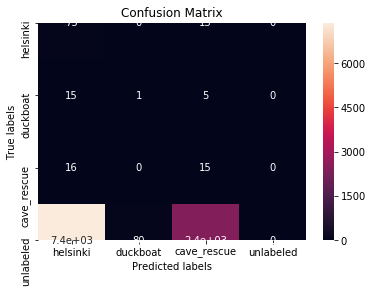

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

labels = articles['label'].unique()
cm = confusion_matrix(list(articles['label']), list(articles['prediction']), labels)

print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = sns.heatmap(cm, annot=True, ax = ax);
plt.title('Confusion matrix of the classifier')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [40]:
cm_without_unlabeled = cm[:-1, :-1]
acc = np.trace(cm_without_unlabeled)/np.sum(cm_without_unlabeled)
print("Accuracy: ", acc)

Accuracy:  0.65


In [41]:
cm_without_unlabeled

array([[75,  0, 13],
       [15,  1,  5],
       [16,  0, 15]])

In [42]:
labeled_articles = articles.dropna(subset=['label'])
concat_labeled_articles = list(labeled_articles[['text','prediction']].groupby(['prediction'])['text'].apply(lambda x: ' '.join(x)))
# df[['name','text','month']].drop_duplicates()

## Tf-idf using 2 groups

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(concat_labeled_articles)

In [44]:
vectors.todense()

matrix([[2.56719534e-03, 7.80226035e-03, 0.00000000e+00, ...,
         1.70456453e-05, 3.40912906e-05, 3.40912906e-05],
        [3.41573915e-03, 3.65972051e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.30455656e-03, 7.83451100e-03, 1.13375899e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [45]:
tfidfs = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())

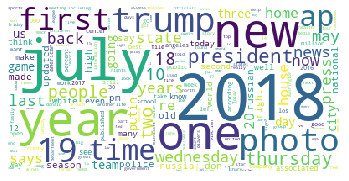

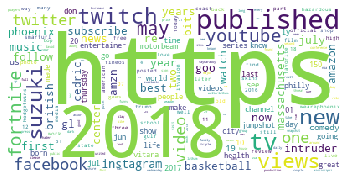

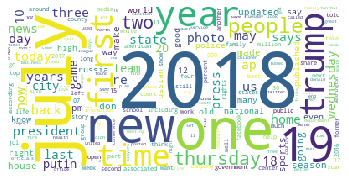

In [46]:
from wordcloud import WordCloud, STOPWORDS

stopwords = STOPWORDS
stopwords.update(["said", "will"])
for i in range(0, len(tfidfs)):
    d = {}
    for k,v in tfidfs.T[i].reset_index().values:
        d[k] = v
    d = {key: d[key] for key in d if key not in stopwords}
            
    wordcloud = WordCloud(background_color = 'white', stopwords=stopwords)
    wc = wordcloud.fit_words(d)
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")

## Averaged tf-idf among each group

In [47]:
def avg_tfidf(clustered_articles):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(clustered_articles)
    return np.mean(vectors, axis = 0), vectorizer

In [48]:
avg_tfidf(labeled_articles[labeled_articles['prediction'] == 'helsinki']['text'])

(matrix([[3.58021803e-03, 5.00336766e-03, 1.50125985e-05, ...,
          2.27299175e-05, 7.51983890e-06, 7.51983890e-06]]),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None))

In [49]:
averaged_tfidfs = labeled_articles[['text','prediction']].groupby(['prediction'])['text'].agg(avg_tfidf)

In [50]:
averaged_tfidfs[1]

(matrix([[0.00182367, 0.00357969, 0.00164569, ..., 0.00042848, 0.00042848,
          0.00042848]]),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None))

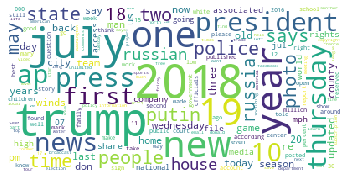

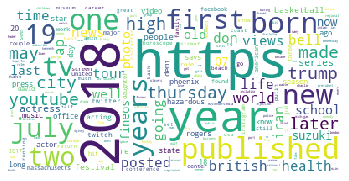

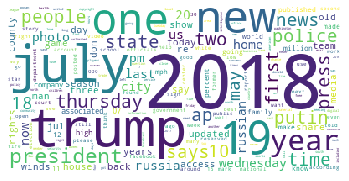

In [51]:
for i in range(0, len(averaged_tfidfs)):
    tf, vec = averaged_tfidfs[i]
    wordcloud = WordCloud(background_color = 'white')
    tfidfs = pd.DataFrame(tf, columns=vec.get_feature_names())
    d = {}
    for k,v in tfidfs.T.reset_index().values:
        d[k] = v
    d = {key: d[key] for key in d if key not in stopwords}
    wc = wordcloud.generate_from_frequencies(d)
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")

## Naming clusters

### Assume perfect clustering algorithm

In [52]:
helsinki_idx =  articles.index[articles['label'] == 'helsinki'].tolist()

In [53]:
# helsinki_idx

In [54]:
import spacy
#get the noun, verb, word entity for each articles
nlp = spacy.load("en_core_web_sm")
noun_phrases_list = []
verb_phrases_list = []
entites_list = []
for text in articles['text']:
    doc = nlp(text)
    noun_phrases_list.append([chunk.text for chunk in doc.noun_chunks])
    verb_phrases_list.append([token.lemma_ for token in doc if token.pos_ == "VERB"])
    entites_list.append([entity.text for entity in doc.ents])

In [55]:
len(entites_list)

10009

In [56]:
sum(np.array(entites_list) == 'Helsinki')

0

In [57]:
import re

cleaned_entity_list = [[re.sub('[^0-9a-zA-Z ]+', '', ent).strip() for ent in entites] for entites in entites_list]
cleaned_entity_list = [[ce for ce in cleaned_entities if ce != ''] for cleaned_entities in cleaned_entity_list]

In [58]:
N = len(cleaned_entity_list)

In [59]:
wordSet = set().union(*[set(lis) for lis in cleaned_entity_list])

In [60]:
wordDicts = [dict.fromkeys(wordSet, 0)] * len(cleaned_entity_list)


In [61]:
wordDF = pd.DataFrame(wordDicts)

In [62]:
for idx, art in enumerate(cleaned_entity_list):
    for word in art:
        wordDF.iloc[idx][word]+=1

In [63]:
helsinki = wordDF.iloc[helsinki_idx]

In [64]:
import math
idf = np.log10(N/np.sum(helsinki))

In [65]:
topic_tfidf = helsinki*idf

In [66]:
np.mean(topic_tfidf['Helsinki'])

3.2193760543634795

In [67]:
# Expect to see 'Helsinki' somewhere on top
top_n = 40
top_n_keywords = np.mean(topic_tfidf).sort_values(ascending=False)[:top_n]
top_n_keywords

Trump                7.761924
Russian              6.268011
Russia               6.212580
Putin                5.884656
US                   5.815392
Vladimir Putin       3.524749
Donald Trump         3.312240
Helsinki             3.219376
Thursday             2.431399
2016                 2.165485
the White House      2.092652
Trumps               1.944310
American             1.830544
Republicans          1.792111
Washington           1.772795
Wednesday            1.733959
Monday               1.733959
Democrats            1.694845
one                  1.675181
NATO                 1.615750
the United States    1.555636
Senate               1.474362
Russians             1.391725
Moscow               1.286358
Republican           1.264991
first                1.264991
today                1.243520
Tuesday              1.200262
Coats                1.178469
two                  1.178469
America              1.112408
Americans            1.067770
AP                   1.022625
White Hous